In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import math

In [2]:
class PrimalDualInteriorPointSolver:
    """
    Resolve um problema de programação linear (PL) na forma padrão usando o
    Método de Pontos Interiores Primal-Dual.

    Esta classe implementa um algoritmo que converge para a solução ótima ao
    dar passos de Newton em direção a um "caminho central". A deteção de status
    de problemas ilimitados ou infactíveis é feita analisando a tendência de
    convergência dos resíduos primal e dual ao longo das iterações.
    """
    def __init__(self, A, b, c, alpha=0.1, beta=0.995, tol=1e-7, max_iter=100, history_size=None):
        """
        Inicializa o solver com os dados do problema e os parâmetros do algoritmo.

        Args:
            A (np.ndarray): Matriz de restrições (m x n).
            b (np.ndarray): Vetor do lado direito das restrições (m x 1).
            c (np.ndarray): Vetor de custos da função objetivo (n x 1).
            alpha (float): Fator de redução do parâmetro de centralização.
            beta (float): Fator de recuo do passo para manter a interioridade.
            tol (float): Tolerância para o critério de parada.
            max_iter (int): Número máximo de iterações.
            history_size (int, optional): Tamanho da janela de histórico para detetar
                                           estagnação. Padrão é 10% de max_iter.
        """
        m, n = A.shape
        if b.shape[0] != m or b.ndim > 1: raise ValueError(f"Dimensão de 'b' ({b.shape}) incompatível com 'A' ({A.shape}).")
        if c.shape[0] != n or c.ndim > 1: raise ValueError(f"Dimensão de 'c' ({c.shape}) incompatível com 'A' ({A.shape}).")
        
        self.A, self.b, self.c = A, b, c
        self.m, self.n = m, n
        self.alpha, self.beta, self.tol, self.max_iter = alpha, beta, tol, max_iter
        self.statistics = {}

        # Caso history_size não seja informado, ele será equivalente a 10% (arredondar para cima)
        # da quantidade de iterações
        if history_size is None:
            self.history_size = int(math.ceil(max_iter / 10))
        else:
            self.history_size = int(history_size)

    def calculate_central_path(self, num_points=50, initial_gap=10):
        """
        Calcula uma aproximação do caminho central teórico do problema.
        """
        path_points = []
        x, lam, mu = self.find_starting_point(self.A, self.b, self.c, verbose=False)
        deltas = np.logspace(np.log10(initial_gap), np.log10(self.tol * 10), num_points)
        for delta in deltas:
            for _ in range(15):
                rp, rd = self.b - self.A @ x, self.c - self.A.T @ lam - mu
                dx, dlam, dmu = self._solve_newton_system(x, lam, mu, rp, rd, delta, verbose=False)
                theta = self._calculate_step_size(x, mu, dx, dmu)
                x, lam, mu = x + theta * dx, lam + theta * dlam, mu + theta * dmu
                if np.linalg.norm(rp) < self.tol * 10 and np.linalg.norm(rd) < self.tol * 10: break
            if x.shape[0] >= 2:
                path_points.append(x[:2].copy())
        self.statistics['central_path'] = path_points
        return np.array(path_points)

    @staticmethod
    def find_starting_point(A, b, c, verbose=True):
        """
        Encontra um ponto inicial (x0, lambda0, mu0) com x0 > 0 e mu0 > 0
        usando uma heurística padrão.
        """
        m, n = A.shape
        try:
            AAT_inv = np.linalg.inv(A @ A.T)
            x_hat, lambda_hat = A.T @ AAT_inv @ b, AAT_inv @ A @ c
        except np.linalg.LinAlgError:
            if verbose: print("Aviso: A @ A.T é singular. Usando lstsq como fallback.")
            x_hat, lambda_hat = np.linalg.lstsq(A, b, rcond=None)[0], np.linalg.lstsq(A.T, c, rcond=None)[0]
        
        mu_hat = c - A.T @ lambda_hat
        delta_x = max(-1.5 * np.min(x_hat), 1e-4) if np.any(x_hat < 0) else 1e-4
        delta_mu = max(-1.5 * np.min(mu_hat), 1e-4) if np.any(mu_hat < 0) else 1e-4
        x0, mu0 = x_hat + delta_x, mu_hat + delta_mu
        
        if verbose:
            print("--- Ponto Inicial Heurístico Encontrado ---")
            print(f"  Norma de x0: {np.linalg.norm(x0):.4f}, Mín(x0): {np.min(x0):.4f}")
            print(f"  Norma de μ0: {np.linalg.norm(mu0):.4f}, Mín(μ0): {np.min(mu0):.4f}")
        
        return x0, lambda_hat, mu0

    def solve(self, x0, lambda0, mu0, verbose=True):
        """
        Executa o algoritmo Primal-Dual e retorna a solução e o status de terminação.

        Returns:
            tuple: Uma tupla (x, lambda, mu, k, status) contendo a solução final,
                   o número de iterações e o status ('optimal', 'infeasible',
                   'unbounded', 'max_iter_reached').
        """
        if verbose: print("\n--- Iniciando o Método de Pontos Interiores Primal-Dual ---")
        
        # Inicializa listas para armazenar estatísticas
        path_data = []
        primal_residuals_data = []
        dual_residuals_data = []

        if x0.shape[0] >= 2:
            path_data.append(x0[:2].copy())
        
        k, x, lam, mu = 0, x0.copy(), lambda0.copy(), mu0.copy()
        status = 'running'
        
        rp_history = deque(maxlen=self.history_size)
        rd_history = deque(maxlen=self.history_size)
        last_rp_mean = np.inf
        last_rd_mean = np.inf

        while k < self.max_iter:
            if verbose: print(f"\n--- Iteração {k} ---")
            
            rp, rd, gap = self.b - self.A @ x, self.c - self.A.T @ lam - mu, x.T @ mu
            norm_rp, norm_rd = np.linalg.norm(rp), np.linalg.norm(rd)
            
            # Adiciona os dados da iteração atual para as estatísticas
            primal_residuals_data.append(norm_rp)
            dual_residuals_data.append(norm_rd)
            rp_history.append(norm_rp)
            rd_history.append(norm_rd)
            
            if verbose:
                print(f"  Gap: {gap:.4e}, Resíduo Primal: {norm_rp:.4e}, Resíduo Dual: {norm_rd:.4e}")

            if norm_rp < self.tol and norm_rd < self.tol and gap < self.tol:
                status = 'optimal'; break
            
            if len(rp_history) == self.history_size:
                current_rp_mean = np.mean(rp_history)
                current_rd_mean = np.mean(rd_history)
                stagnation_factor = 0.999 

                if last_rp_mean != np.inf:
                    if current_rd_mean >= last_rd_mean * stagnation_factor:
                    #and current_rp_mean < last_rp_mean * stagnation_factor:
                        status = 'unbounded'; break
                    if current_rp_mean >= last_rp_mean * stagnation_factor:
                    #and current_rd_mean < last_rd_mean * stagnation_factor:
                        status = 'infeasible'; break
                
                last_rp_mean = current_rp_mean
                last_rd_mean = current_rd_mean

            delta = self.alpha * (gap / self.n)
            dx, dlam, dmu = self._solve_newton_system(x, lam, mu, rp, rd, delta, verbose)
            theta = self._calculate_step_size(x, mu, dx, dmu)
            x, lam, mu = x + theta * dx, lam + theta * dlam, mu + theta * dmu
            
            if x.shape[0] >= 2:
                path_data.append(x[:2].copy())
            k += 1

        if status == 'running': status = 'max_iter_reached'
        if verbose: print(f"\nExecução terminada na iteração {k} com status: '{status}'")
        
        self.statistics['path'] = path_data
        self.statistics['primal_residuals'] = primal_residuals_data
        self.statistics['dual_residuals'] = dual_residuals_data
        
        return x, lam, mu, k, status

    def plot_residuals(self):
        """
        Plota a convergência dos resíduos primal e dual ao longo das iterações.

        Este método deve ser chamado após a execução do `solve`. Ele gera um
        gráfico mostrando a norma de cada resíduo por iteração em uma escala
        logarítmica para melhor visualização da convergência.
        """
        if not self.statistics.get('primal_residuals') or not self.statistics.get('dual_residuals'):
            print("Não há dados de resíduos para plotar. Execute o método `solve` primeiro.")
            return

        primal_res = self.statistics['primal_residuals']
        dual_res = self.statistics['dual_residuals']
        iterations = range(len(primal_res))

        plt.figure(figsize=(12, 7))
        plt.plot(iterations, primal_res, 'b-o', label='Resíduo Primal (||b - Ax||)', markersize=4, alpha=0.8)
        plt.plot(iterations, dual_res, 'r-s', label='Resíduo Dual (||c - Aᵀλ - μ||)', markersize=4, alpha=0.8)
        
        plt.yscale('log')
        plt.xlabel('Iteração')
        plt.ylabel('Norma do Resíduo (Escala Log)')
        plt.title('Convergência dos Resíduos Primal e Dual')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

    def _solve_newton_system(self, x, lam, mu, rp, rd, delta, verbose=True):
        """Resolve o sistema de Newton para a direção de busca."""
        rc = delta - x * mu
        theta_inv_diag = mu / (x + 1e-25)
        lhs_lambda = self.A @ (self.A.T.T * (1 / (theta_inv_diag + 1e-25))).T
        rhs_lambda = rp + self.A @ ((rd - rc / (x + 1e-25)) / (theta_inv_diag + 1e-25))
        try: dlam = np.linalg.solve(lhs_lambda, rhs_lambda)
        except np.linalg.LinAlgError:
            if verbose: print("  Aviso: Sistema singular para Δλ. Usando lstsq.")
            dlam = np.linalg.lstsq(lhs_lambda, rhs_lambda, rcond=None)[0]
        dmu = rd - self.A.T @ dlam
        dx = (rc - x * dmu) / (mu + 1e-25)
        return dx, dlam, dmu

    def _calculate_step_size(self, x, mu, dx, dmu):
        """Calcula o passo para manter x e mu positivos."""
        alpha_p = 1.0; alpha_d = 1.0
        for i in range(self.n):
            if dx[i] < -1e-12: alpha_p = min(alpha_p, -x[i] / dx[i])
            if dmu[i] < -1e-12: alpha_d = min(alpha_d, -mu[i] / dmu[i])
        return self.beta * min(alpha_p, alpha_d)


In [3]:
def plot_results(solver, A_orig, b_orig, central_path_points=None):
    """
    Plota a região factível e o caminho percorrido pelo algoritmo para problemas 2D.
    Esta versão é genérica e funciona para qualquer conjunto de restrições lineares.
    """
    path = np.array(solver.statistics['path'])
    
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)

    # Define os limites do gráfico com base nos pontos visitados e nas restrições
    x_max_path = path[:, 0].max()
    y_max_path = path[:, 1].max()

    # Interceptos em X e Y das restrições para ajudar a definir os limites
    with np.errstate(divide='ignore', invalid='ignore'):
        x_intercepts = b_orig[A_orig[:, 0] != 0] / A_orig[A_orig[:, 0] != 0, 0]
        y_intercepts = b_orig[A_orig[:, 1] != 0] / A_orig[A_orig[:, 1] != 0, 1]
    
    x_max = max(x_max_path, np.max(x_intercepts[x_intercepts > 0]) if np.any(x_intercepts > 0) else x_max_path) + 1
    y_max = max(y_max_path, np.max(y_intercepts[y_intercepts > 0]) if np.any(y_intercepts > 0) else y_max_path) + 1
    
    ax.set_xlim(-1, x_max)
    ax.set_ylim(-1, y_max)

    # --- Desenha a Região Factível (Método Genérico) ---
    x_grid = np.linspace(-1, x_max, 400)
    y_grid = np.linspace(-1, y_max, 400)
    xx, yy = np.meshgrid(x_grid, y_grid)
    
    feasible_region = np.ones_like(xx, dtype=bool)
    for i in range(A_orig.shape[0]):
        a1, a2 = A_orig[i, 0], A_orig[i, 1]
        b_val = b_orig[i]
        feasible_region &= (a1 * xx + a2 * yy <= b_val + 1e-9) # Tolerância numérica
    feasible_region &= (xx >= -1e-9)
    feasible_region &= (yy >= -1e-9)
    
    ax.contourf(xx, yy, feasible_region, levels=[0.5, 1.5], colors=['cyan'], alpha=0.3)
    ax.contour(xx, yy, feasible_region, levels=[0.5], colors=['blue'], linewidths=1.5)

    # --- Plota as Linhas de Restrição ---
    for i in range(A_orig.shape[0]):
        a1, a2, b_val = A_orig[i, 0], A_orig[i, 1], b_orig[i]
        
        label = f'{a1 if a1!=1 else ""}x₁ + {a2 if a2!=1 else ""}x₂ = {b_val}'.replace('+ -','- ').replace('1x','x')
        
        if np.abs(a2) > 1e-9:
            y_plot = (b_val - a1 * x_grid) / a2
            ax.plot(x_grid, y_plot, color='gray', alpha=0.9, label=label)
        elif np.abs(a1) > 1e-9:
            ax.axvline(x=b_val / a1, color='gray', alpha=0.9, label=label)

    # --- Plota os Caminhos ---
    if central_path_points is not None:
        ax.plot(central_path_points[:, 0], central_path_points[:, 1], 'k--', linewidth=2, label='Caminho Central (Teórico)')

    ax.plot(path[:, 0], path[:, 1], 'o-', color='orange', markersize=5, linewidth=2, label='Caminho do Solver')
    ax.plot(path[0, 0], path[0, 1], 'go', markersize=10, label='Ponto Inicial')
    ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=15, label='Ponto Ótimo')
    
    ax.set_xlabel("x₁", fontsize=14)
    ax.set_ylabel("x₂", fontsize=14)
    ax.set_title("Caminho do Método de Pontos Interiores vs. Caminho Central", fontsize=16)
    ax.legend(loc='best')
    plt.show()

In [4]:
# --- Definição do Problema Original ---
# min -x1 -2x2
# s.t.
#   x1 + x2 <= 6
#   x1 - x2 <= 4
#  -x1 + x2 <= 4
#   x1, x2 >= 0
A_orig = np.array([[1,1], [1,-1], [-1,1]])
b_orig = np.array([6, 4, 4])

# --- Conversão para a Forma Padrão ---
A = np.array([[1, 1, 1, 0, 0], [1, -1, 0, 1, 0], [-1, 1, 0, 0, 1]])
b = np.array([6, 4, 4])
c = np.array([-1, -2, 0, 0, 0])

# 1. Instancia o solver
solver = PrimalDualInteriorPointSolver(A, b, c, tol=1e-8)

# 2. Encontra um ponto inicial
x0, lambda0, mu0 = solver.find_starting_point(A, b, c, verbose=False)

# 3. Resolve o problema
x_opt, _, _, iters, status = solver.solve(x0, lambda0, mu0, verbose=False)


RESULTADO FINAL: Status 'optimal'
Solução ótima encontrada em 10 iterações.

Variáveis de decisão:
  x1 = 1.0
  x2 = 5.0

Valor da função objetivo: -11.000000


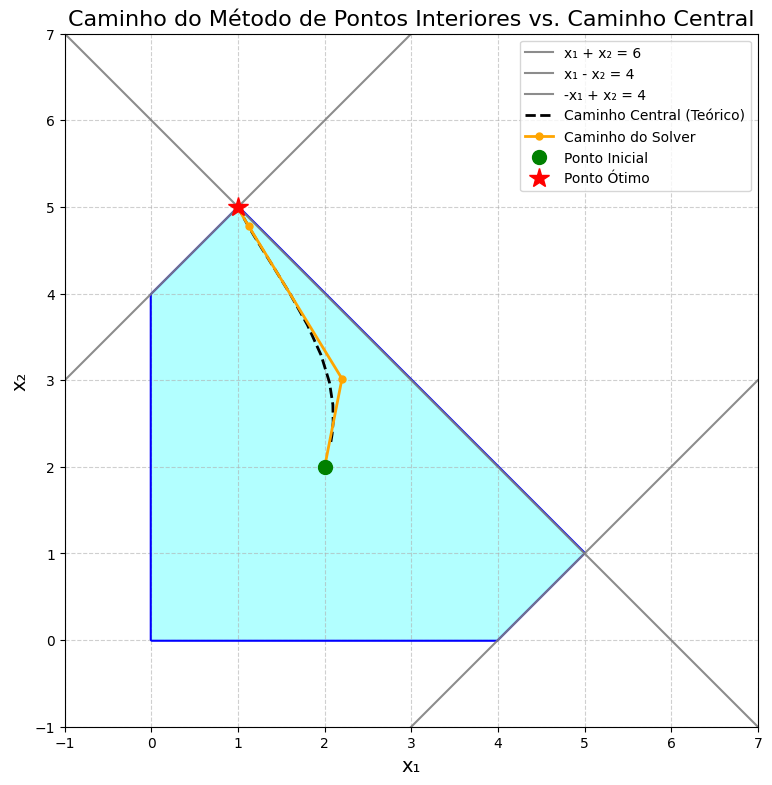

In [5]:
# 4. Exibe os resultados finais
print("\n" + "="*50 + f"\nRESULTADO FINAL: Status '{status}'\n" + "="*50)
print(f"Solução ótima encontrada em {iters} iterações.")
x_opt_rounded = np.round(x_opt, 6)
print("\nVariáveis de decisão:")
print(f"  x1 = {x_opt_rounded[0]}")
print(f"  x2 = {x_opt_rounded[1]}")
obj_value = c @ x_opt
print(f"\nValor da função objetivo: {obj_value:.6f}")
print("="*50)

# 5. Plota o gráfico dos resultados
central_path = solver.calculate_central_path()
plot_results(solver, A_orig, b_orig, central_path_points=central_path)

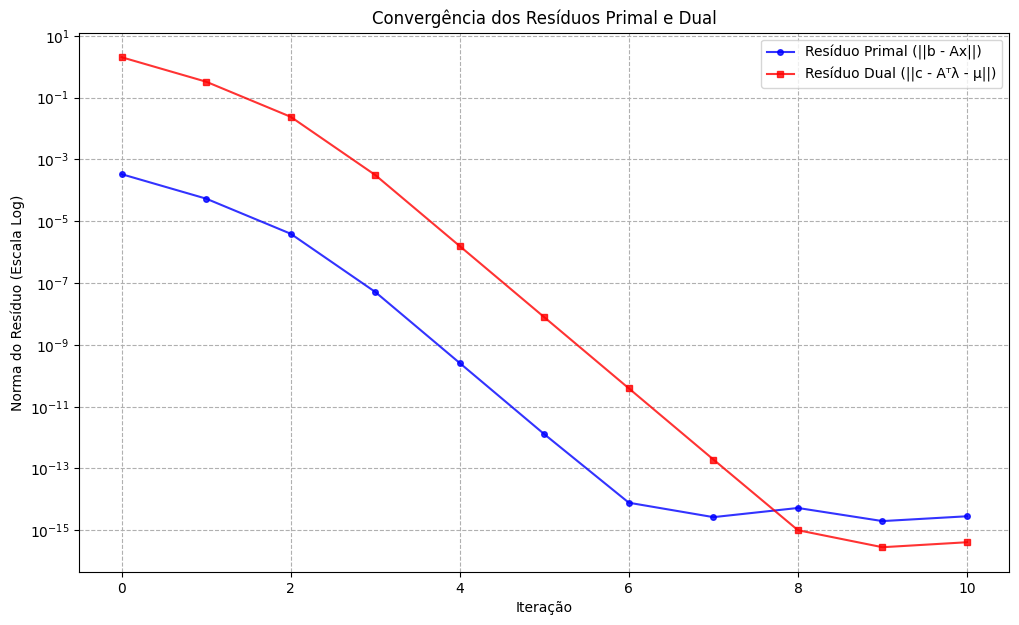

In [6]:
solver.plot_residuals()

In [7]:
from parser import parse_model_from_txt

In [8]:
model_filepath = r'./modelos/teste.txt'

# Obter o modelo original (sem vars de folga) para plotagem e cálculo do objetivo
parsed_model_orig = parse_model_from_txt(model_filepath, to_standard_form=False)
A_orig = np.array(parsed_model_orig['A'])
b_orig = np.array(parsed_model_orig['b'])

# Recupera o vetor de custos original com base no tipo de otimização
c_orig = -np.array(parsed_model_orig['c']) if parsed_model_orig['was_min'] else np.array(parsed_model_orig['c'])

# Obter o modelo na forma padrão para o solver
print("--- Convertendo o modelo para a Forma Padrão ---")
parsed_model_std = parse_model_from_txt(model_filepath, to_standard_form=True)

A = np.array(parsed_model_std['A'])
b = np.array(parsed_model_std['b'])

# O solver é um MINIMIZADOR. O parser converte tudo para um problema de MAX.
# Portanto, para minimizar, precisamos pegar o negativo dos custos retornados pelo parser.
c = -np.array(parsed_model_std['c'])

--- Convertendo o modelo para a Forma Padrão ---


In [9]:
# --- Passo 2: Instanciar e Resolver com o Solver ---
solver = PrimalDualInteriorPointSolver(A, b, c, tol=1e-8, max_iter=5)

print("\n--- Calculando o Caminho Central Teórico ---")
central_path = solver.calculate_central_path()

x0, lambda0, mu0 = solver.find_starting_point(A, b, c, verbose=False)
x_opt, _, _, iters, status = solver.solve(x0, lambda0, mu0, verbose=False)


--- Calculando o Caminho Central Teórico ---



RESULTADO FINAL: Status 'max_iter_reached'
Solução ótima encontrada em 5 iterações.

Variáveis de decisão:
  x1 = 1.343878
  x2 = 1.63923
  x3 = 0.643538
  x4 = 5.7e-05

Valor da função objetivo: -4.970468


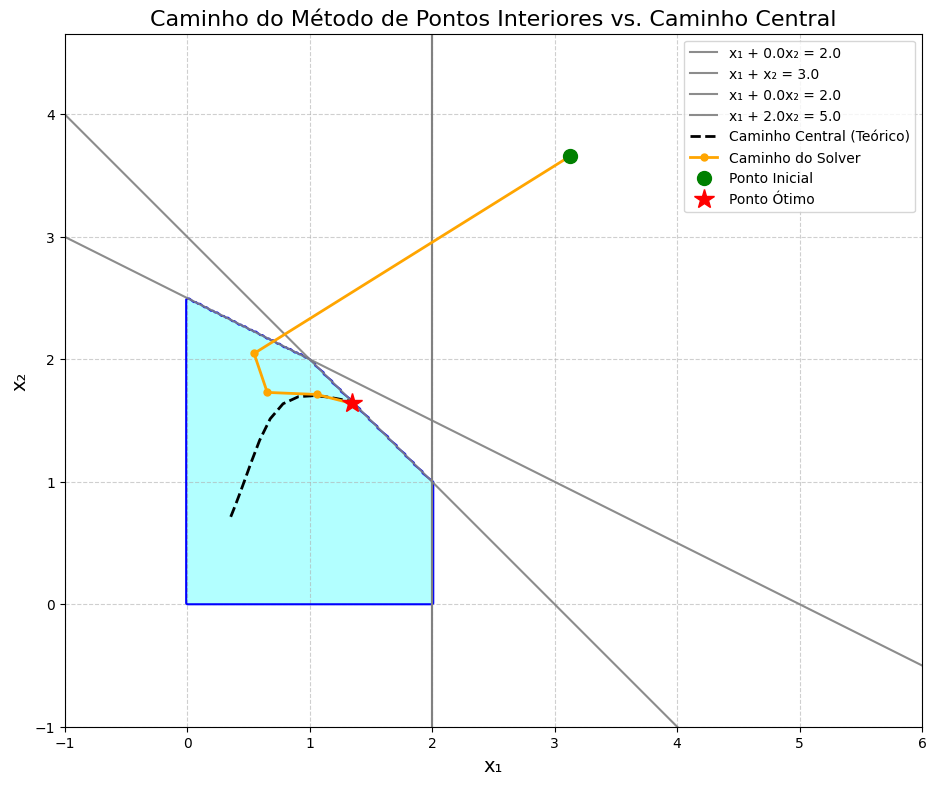

In [10]:
# --- Passo 3: Exibir e Plotar os Resultados ---
print("\n" + "="*50 + f"\nRESULTADO FINAL: Status '{status}'\n" + "="*50)

if status != 'infeasible':
    print(f"Solução ótima encontrada em {iters} iterações.")
    num_orig_vars = A_orig.shape[1]
    x_opt_rounded = np.round(x_opt[:num_orig_vars], 6)

    print("\nVariáveis de decisão:")
    for i in range(num_orig_vars):
        print(f"  x{i+1} = {x_opt_rounded[i]}")

    # Calcula valor objetivo com custos originais
    obj_value = c_orig @ x_opt[:num_orig_vars]
    print(f"\nValor da função objetivo: {obj_value:.6f}\n" + "="*50)

    plot_results(solver, A_orig, b_orig, central_path_points=central_path)

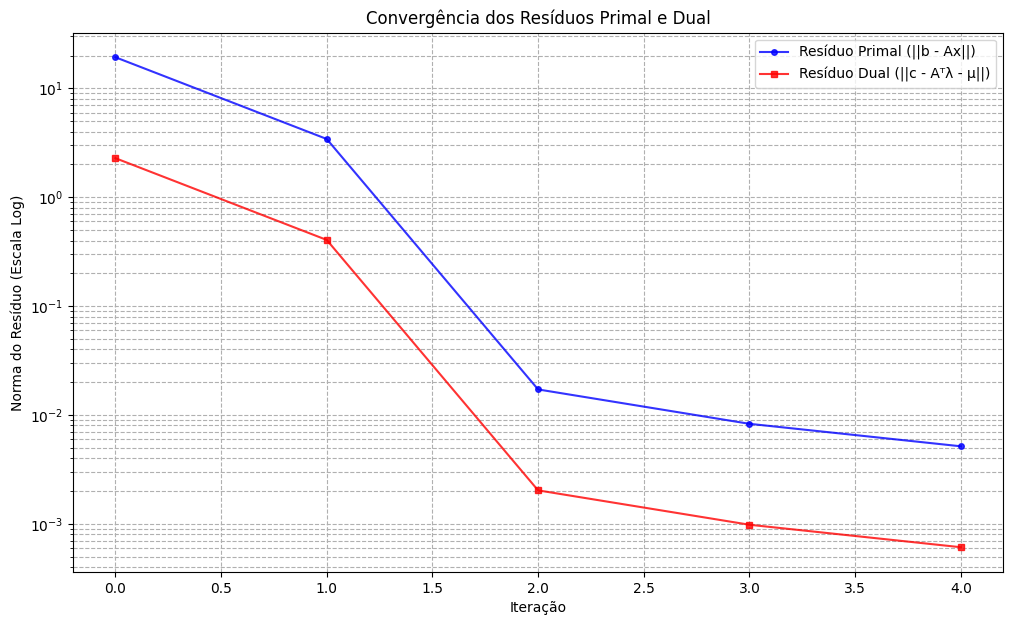

In [11]:
solver.plot_residuals()